In [2]:
from torch import nn
from transformers import BertModel
import torch

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

model = BertClassifier()
model.load_state_dict(torch.load(r"C:\Users\samue\OneDrive - HKUST Connect\year 2 spring\UROP 1100\UROP-1100-21S\article_bias\subjectivity\model.pth"))
model.eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [3]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        #self.labels = list(df['subjective'])
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [28]:
from scipy.special import softmax

def predict(model, data):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()

    tokens = tokenizer(data, 
                            padding='max_length', max_length = 512, truncation=True,
                            return_tensors="pt")
    
    mask = tokens['attention_mask'].to(device)
    input_id = tokens['input_ids'].squeeze(1).to(device)

    output = model(input_id, mask)
    output = output[0].cpu().data.numpy()
    output = softmax(output)
        
    return output[1]


    
result = predict(model, "This is good")

In [18]:
import pandas as pd
df = pd.read_csv(r"C:\Users\samue\OneDrive - HKUST Connect\year 2 spring\UROP 1100\UROP-1100-21S\source_bias\labelled_news_data.csv")
df.head()

,id,title,publication,author,date,year,month,url,content,media_bias,label
0,82596,Donald Trump blasts Bill Clinton as ’one of th...,Fox News,Christopher Snyder,2015-12-30,2015.0,12.0,https://web.archive.org/web/20160101000951/htt...,Donald Trump launched new attacks against Bil...,right,POLITICS
1,82600,"Drop in oil prices rocks producer states, trig...",Fox News,Brooke Singman,2016-01-01,2016.0,1.0,https://web.archive.org/web/20160102032517/htt...,The plunge in oil prices has given a needed b...,right,BUSINESS
2,82605,Open carry comes to Texas: Why the Lone Star s...,Fox News,John R Lott,2015-12-30,2015.0,12.0,https://web.archive.org/web/20160102032517/htt...,"With about 900, 000 concealed handgun permit ...",right,POLITICS
3,82621,GOP field rips Obama’s move toward executive a...,Fox News,Joseph Weber,2016-01-03,2016.0,1.0,https://web.archive.org/web/20160104001421/htt...,Republican presidential candidates are attack...,right,POLITICS
4,82630,President Obama wants to disarm America,Fox News,Todd Starnes,2016-01-04,2016.0,1.0,https://web.archive.org/web/20160105014544/htt...,President Obama is plotting with his attorney...,right,POLITICS


In [24]:
politics = df[df['label'] == 'POLITICS']
politics = politics[['title', 'content', 'url', 'publication', 'media_bias', 'label']]
politics.head()

,title,content,url,publication,media_bias,label
0,Donald Trump blasts Bill Clinton as ’one of th...,Donald Trump launched new attacks against Bil...,https://web.archive.org/web/20160101000951/htt...,Fox News,right,POLITICS
2,Open carry comes to Texas: Why the Lone Star s...,"With about 900, 000 concealed handgun permit ...",https://web.archive.org/web/20160102032517/htt...,Fox News,right,POLITICS
3,GOP field rips Obama’s move toward executive a...,Republican presidential candidates are attack...,https://web.archive.org/web/20160104001421/htt...,Fox News,right,POLITICS
4,President Obama wants to disarm America,President Obama is plotting with his attorney...,https://web.archive.org/web/20160105014544/htt...,Fox News,right,POLITICS
5,"Rancher family reports to prison, does not end...",As armed protesters occupied buildings on a f...,https://web.archive.org/web/20160105014544/htt...,Fox News,right,POLITICS


In [30]:
politics['subjectivity'] = politics.apply(lambda x: predict(model, x['content']), axis=1)


<AxesSubplot:ylabel='Frequency'>

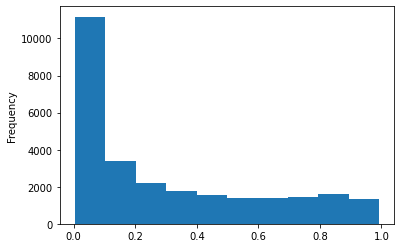

In [32]:
politics.subjectivity.plot(kind='hist')